<a href="https://colab.research.google.com/github/Jack3690/Kugelblitz/blob/main/notebooks/Dusty_MaNGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install packaging==21 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 21.0 which is incompatible.
xarray 2022.12.0 requires packaging>=21.3, but you have packaging 21.0 which is incompatible.


In [ ]:
!pip install sdss-marvin --quiet
!pip install photutils --quiet
!pip install pafit --quiet
!pip install Flask==2.1.0 --quiet

In [1]:
import os
import sys
import requests
import warnings
import PIL
import copy
from astropy.io import fits
if sys.version_info.major == 2:
    from cStringIO import StringIO as stringio
else:
    from io import StringIO as stringio
    from io import BytesIO as bytesio

In [2]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sb
import matplotlib
import numpy as np
from matplotlib import gridspec
import pandas as pd
import marvin.utils.plot.colorbar as colorbar
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import photutils as phot
from photutils import isophote as iso
import os
import json


from marvin.tools.maps import Maps
import marvin.utils.plot.map as mapplot
from astropy.table import Table, join
import astropy.units as u
from astropy.io import ascii
from astropy.modeling import models,fitting
from scipy.interpolate import griddata
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import Planck15
from photutils import aperture as aper
from astropy.coordinates import SkyCoord

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.wcs import WCS

import photutils as phot
from photutils.segmentation import SourceCatalog, deblend_sources, detect_sources

from pafit import fit_kinematic_pa as paf

matplotlib.rcParams['figure.figsize']=(10,10)
matplotlib.rcParams['font.size']= 20

sb.set_style('white')

DEBUG:sdss_access:SDSS_ACCESS> Using Tree(sas_base_dir=/root/sas, config=sdsswork, release=WORK)
[WARNING]: cannot initiate Sentry error reporting: [Errno 6] No such device or address. (UserWarning)
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),

[INFO]: No release version set. Setting default to DR17
INFO:marvin:No release version set. Setting default to DR17
[WARNING]: path /root/sas/dr17/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
  warnings.warn('path {0} cannot be found. Setting dapall to None.'

[WARNING]: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module() (ImportWarning)

[WARNING]: _PyDriveImportHook.find_spec() not found; falling back to find_module() (ImportWarning)

[WARNING]: _OpenCVImportHook.find_spec() not found; falling back to find_module() (ImportWarning)

[WARNING]: _BokehImportHook.find_spec() not found; falling back to find_mo

In [3]:
from marvin import config
# set the release
config.setRelease("DR17")

[WARNING]: path /root/sas/dr17/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
  warnings.warn('path {0} cannot be found. Setting dapall to None.'



In [4]:
class Cutout_L(object):
    """ A Generic SDSS Cutout Image

    Tool which allows to generate an image using the SDSS Skyserver
    Image Cutout service.  See http://skyserver.sdss.org/public/en/help/docs/api.aspx#imgcutout
    for details.

    Parameters:
        ra (float):
            The central Right Ascension of the cutout
        dec (float):
            The central Declination of the cutout
        width (int):
           width of cutout in arcsec
        height (int):
            height in cutout in arcsec
        scale (float):
            pixel scale in arcsec/pixel.  Default is 0.262 "/pix.

    Attributes:
        rawurl (str):
            The raw url of the cutout
        wcs (WCS):
            The WCS of the generated image
        image (PIL.Image):
            The cutout image object
        size (int):
            The image size in arcsec
        size_pix (int):
            The image size in pixels
        center (tuple):
            The image center RA, Dec

    """

    def __init__(self, ra, dec, width, height, layers=None, scale=None, **kwargs):
        self.rawurl = ("https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&pixscale={scale}&width={width_pix}&height={height_pix}&layer={layers}&bands=grz")
        self.ra = ra
        self.dec = dec
        self.scale = scale or 0.27  # default arcsec/pixel
        self.image = None
        self.layers = 'dr8-resid' if layers=='residual' else 'dr8'
        self.center = np.array([ra, dec])
        self.size   = np.array([width, height], dtype=int)
        self.coords = {'ra': ra, 'dec': dec,
                       'width': width, 'height': height,
                       'scale': self.scale
                      ,'layers':self.layers}
        self._get_pix_size()
        if np.max(self.size_pix) >= 2048:
            raise MarvinError('Requested image size is too large. '
                              'The Skyserver image cutout can only return a size up to 2048 pixels')

        self._define_wcs()
        self._get_cutout(**kwargs)

    def __repr__(self):
        return ('<Cutout (ra={0}, dec={1}, scale={2}, height={3}, '
                'width={4})>,layers={5}'.format(self.ra, self.dec, self.scale, *self.size_pix,self.layers))

    def _get_pix_size(self):
        """height,width converted from arcsec->pixels"""
        self.coords['height_pix'] = int(round(self.coords['height'] / self.scale))
        self.coords['width_pix'] = int(round(self.coords['width'] / self.scale))
        self.size_pix = np.array((self.coords['height_pix'], self.coords['width_pix']))

    def _define_wcs(self):
        """
        Given what we know about the scale of the image,
        define a nearly-correct world coordinate system to use with it.
        """
        w = WCS(naxis=2)
        w.wcs.crpix = self.size_pix / 2
        w.wcs.crval = self.center
        w.wcs.cd = np.array([[-1, 0], [0, 1]]) * self.scale / 3600.
        w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
        w.wcs.cunit = ['deg', 'deg']
        w.wcs.radesys = 'ICRS'
        w.wcs.equinox = 2000.0
        self.wcs = w

    def _wcs_to_dict(self):
        ''' Convert and return the WCS as a dictionary'''
        wcshdr = None
        if self.wcs:
            wcshdr = self.wcs.to_header()
            wcshdr = dict(wcshdr)
            wcshdr = {key: str(val) for key, val in wcshdr.items()}
        return wcshdr

    def _make_metadata(self, filetype=None):
        ''' Make the meta data for the image '''

        if 'png' in filetype:
            meta = PIL.PngImagePlugin.PngInfo()
        else:
            meta = None
            warnings.warn('Can only save WCS metadata with PNG filetype', MarvinUserWarning)

        if meta:
            info = {key: str(val) for key, val in self.image.info.items()}
            for row in info:
                meta.add_text(row, info[row])

        return meta

    def _update_info(self):
        ''' Update the image info dictionary '''

        for key, value in self.image.info.items():
            if isinstance(value, tuple):
                self.image.info[key] = value[0]

        wcsdict = self._wcs_to_dict()
        self.image.info = wcsdict
        self.image.info.update(self.coords)
        self.image.info['wdthpix'] = self.image.info.pop('width_pix')
        self.image.info['hghtpix'] = self.image.info.pop('height_pix')

    def _add_options(self, **kwargs):

        allowed = {'grid': 'G', 'label': 'L', 'photo': 'P', 'spectra': 'S',
                   'target': 'T', 'outline': 'O', 'bound': 'B', 'fields': 'F',
                   'masks': 'M', 'plates': 'Q', 'invert': 'I'}

        opts = []
        for key, value in kwargs.items():
            assert key in allowed.keys(), 'Cutout keyword must be one of: {0}'.format(allowed.keys())
            assert isinstance(value, (bool, type(None))), 'Cutout value can only be a Boolean'
            if value:
                opts.append(allowed[key])

        self.coords['opts'] = ''.join(opts)

    def _get_cutout(self, **kwargs):
        """ Gets an image cutout

        Get a cutout around a point, centered at some RA, Dec (in decimal
        degrees), and spanning width,height (in arcseconds) in size.

        Parameters:
            kwargs:
                Allowed keywords into the SDSS Skyserver Image Cutout

        """
        # add options
        self._add_options(**kwargs)
        # retrieve the image
        url = self.rawurl.format(**self.coords)
        response = requests.get(url)
        if not response.ok:
            print(f"\nImage not found for ra = {self.ra}, dec = {self.dec}\n" )
        else:
            base_image = response.content
            ioop = stringio if sys.version_info.major == 2 else bytesio
            self.image = PIL.Image.open(ioop(base_image))
            self._update_info()

    def save(self, filename, filetype='png'):
        ''' Save the image cutout to a file

        If the filetype is PNG, it will also save the WCS and coordinate
        information as metadata in the image.

        Parameters:
            filename (str):
                The output filename
            filetype (str):
                The output file extension
        '''

        filename, fileext = os.path.splitext(filename)
        extlist = ['.png', '.bmp', '.jpg', '.jpeg', '.tiff', '.gif', '.ppm']
        assert fileext.lower() in extlist, 'Specified filename not of allowed image type: png, gif, tiff, jpeg, bmp'

        meta = self._make_metadata(filetype=filetype)
        self.image.save(filename, filetype, pnginfo=meta)

    def show(self):
        ''' Show the image cutout '''
        if self.image:
            self.image.show()

In [ ]:
!git clone https://github.com/Jack3690/Kugelblitz/ --quiet

In [6]:
cd /content/Kugelblitz

/content/Kugelblitz


# **Data: Dusty Galaxies**

In [7]:
df = pd.read_csv('data/dusty_manga_DR17.csv')

In [8]:
for i, row in df.iterrows():
  if row['M_halo'] < 0:
    row['M_halo'] = '-'


  if row['Sigma'] <0:
    row['Sigma'] ='-'
  print(f"{row['MANGAID']} & {row['Z']} & {row['VC_orien']} & {row['VC_morph']} & {row['M_halo']} & {row['Sigma']}", end=' \\\\')
  print()

1-44479 & 0.0436444 & 4 & 3 & 12.4648 & 0.24103 \\
1-604937 & 0.0313725 & 1 & 2 & 12.2916 & 0.256 \\
1-22876 & 0.0304933 & 3 & 2 & - & 0.02477 \\
1-24425 & 0.0292576 & 1 & 2 & 11.7473 & 0.85227 \\
1-612698 & 0.031147812 & 3 & 2 & 12.7257 & 0.35325 \\
1-77060 & 0.0281608 & 1 & 2 & 11.6979 & 0.02146 \\
1-122400 & 0.06788276 & 1 & 3 & 13.0648 & 0.56816 \\
1-93793 & 0.03134 & 1 & 3 & 13.8873 & 1.4774 \\
1-180028 & 0.0182092 & 1 & 2 & 11.4649 & - \\
1-36878 & 0.0231851 & 1 & 2 & 13.003 & 0.87852 \\
1-37727 & 0.0282047 & 1 & 3 & 11.7752 & 0.17723 \\
1-36420 & 0.0543646 & 1 & 2 & 13.1389 & 0.52142 \\
1-35876 & 0.0416338 & 1 & 2 & - & 0.91092 \\
1-137844 & 0.0323374 & 1 & 2 & 13.4854 & 0.57957 \\
1-138034 & 0.027267 & 1 & 3 & 12.1615 & 0.16787 \\
1-149621 & 0.0270052 & 1 & 2 & 11.7876 & 0.36989 \\
1-164052 & 0.0273569 & 1 & 2 & 11.9298 & 0.54284 \\
1-164077 & 0.0461951 & 1 & 2 & 12.9418 & 0.21533 \\
1-233983 & 0.057054013 & 3 & 3 & 12.7343 & 0.29901 \\
1-236144 & 0.0282139 & 1 & 2 & 11.7158 & 

### **Density**

In [9]:
tab = Table.read('data/dusty_density.fits')

[WARNING]: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module() (ImportWarning)

[WARNING]: _PyDriveImportHook.find_spec() not found; falling back to find_module() (ImportWarning)

[WARNING]: _OpenCVImportHook.find_spec() not found; falling back to find_module() (ImportWarning)

[WARNING]: _BokehImportHook.find_spec() not found; falling back to find_module() (ImportWarning)

[WARNING]: _AltairImportHook.find_spec() not found; falling back to find_module() (ImportWarning)



(array([ 0.,  1., 15., 14., 10.,  3.,  2.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 <BarContainer object of 7 artists>)

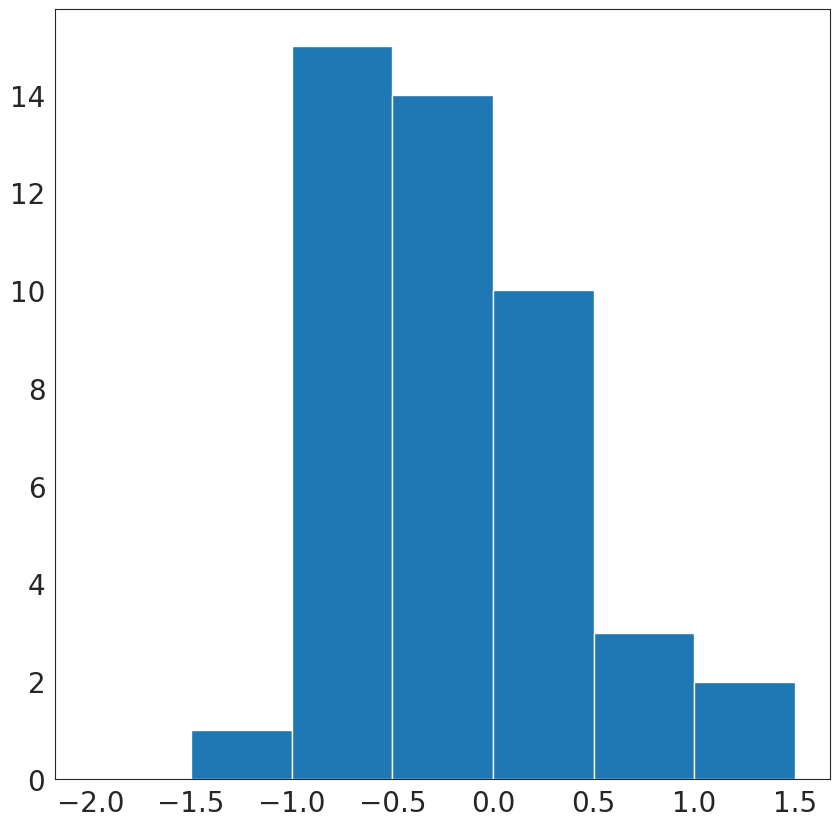

In [10]:
bins = np.arange(-2,2,0.5)
plt.hist(tab['density'],bins)

# **Maps with Matplotlib**

## **Utils**

In [11]:
use_masks = ['NOCOV', 'UNRELIABLE', 'DONOTUSE']
def goodspax(dapmap, SNR = 1.0,type=None):
    if type==None:
        bad_data = dapmap.pixmask.get_mask(use_masks,dtype = bool)
        low_snr = dapmap.snr <= SNR
        mask = np.logical_or.reduce((bad_data, low_snr))
        mask = np.where(mask==True,np.nan,1)

    elif type=='vel':

        low_snr = dapmap.snr<=SNR
        bad_data = dapmap.pixmask.get_mask(use_masks,dtype = bool)
        mask = np.logical_or.reduce((bad_data, low_snr))
        mask = np.where(mask==True,1e-32,1)

    return dapmap.value*mask

In [12]:
def aperture_gen(models,angle_scale,len_scale, origin = 'center' , a_offset = 0):
    apertures = {}
    for i,model in enumerate(models):

        X_c = model[f'{i+1}_XC'].split('+')[0]
        if '*' in X_c:
          print('Error in X_c')
          X_c = float(X_c[1:-2])
        else:
          X_c = float(X_c)
        if origin == 'center':
          X_c-=64
        X_c*=(len_scale/128)

        Y_c = model[f'{i+1}_YC'].split('+')[0]
        if '*' in Y_c:
          print('Error in Y_c')
          Y_c = float(Y_c[1:-2])
        else:
          Y_c = float(Y_c)

        if origin == 'center':
          Y_c-=64
        Y_c*=(len_scale/128)

        PA = model[f'{i+1}_PA'].split('+')[0]
        if '*' in PA:
          print('Error in PA')
          PA = float(PA[1:-2])
        else:
          PA = float(PA)

        AR = model[f'{i+1}_AR'].split('+')[0]
        if '*' in AR:
          print('Error in AR')
          AR = float(AR[1:-2])
        else:
          AR = float(AR)


        keys = [i.split('_')[-1] for i in model.keys()]
        if'RE' in keys:
            RE = model[f'{i+1}_RE'].split('+')[0]
            if '*' in RE:
                print('Error in X_c')
                RE = float(RE[1:-2])
            else:
                RE = float(RE)

        else:
            RE = model[f'{i+1}_RS'].split('+')[0]
            if '*' in RE:
                print('Error in RS')
                RE = float(RE[1:-2])
            else:
                RE = float(RE)

        RE*=(0.394) # RE in arcseconds
        RE*angle_scale
        a = 2*RE
        b = AR*a
        print(a)
        aperture = aper.EllipticalAperture((X_c,Y_c), a,b,
                                           theta = np.pi/2 +(PA + a_offset)*np.pi/180)
        apertures[f'aper_{i+1}'] = aperture
    return apertures

In [13]:
def get_whan(maps):

    nii=maps.emli40ne_gflux_nii_6585
    ha =maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf  = (logniiha < -0.4)  & (ewha.value > 3)
    sagn = (logniiha > -0.4)  & (ewha.value > 6)
    wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
    rg   = ewha.value < 3
    pg   = (ewha.value < 0.5) & (ewnii.value < 0.5)

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = np.nan

    return value

## **Map Sets 1**

In [20]:
!mkdir Dusty

In [14]:
matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['font.size'] = 20

DEBUG:marvin:local mode failed. Trying remote now.
[WARNING]: divide by zero encountered in power (RuntimeWarning)
  return np.log10(np.e) * ivar**-0.5 / value

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
  return np.log10(np.e) * ivar**-0.5 / value

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
  value=ufunc(self.value),

[WARNING]: invalid value encountered in subtract (RuntimeWarning)
  diff_b_a = subtract(b, a)

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
  logniiha = np.log10(niiha.value)

[WARNING]: invalid value encountered in multiply (RuntimeWarning)
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True

[WARNING]: invalid value encountered in multiply (RuntimeWarning)
  return numpy.abs(self.value * numpy.sqrt(self.ivar))



1-44479


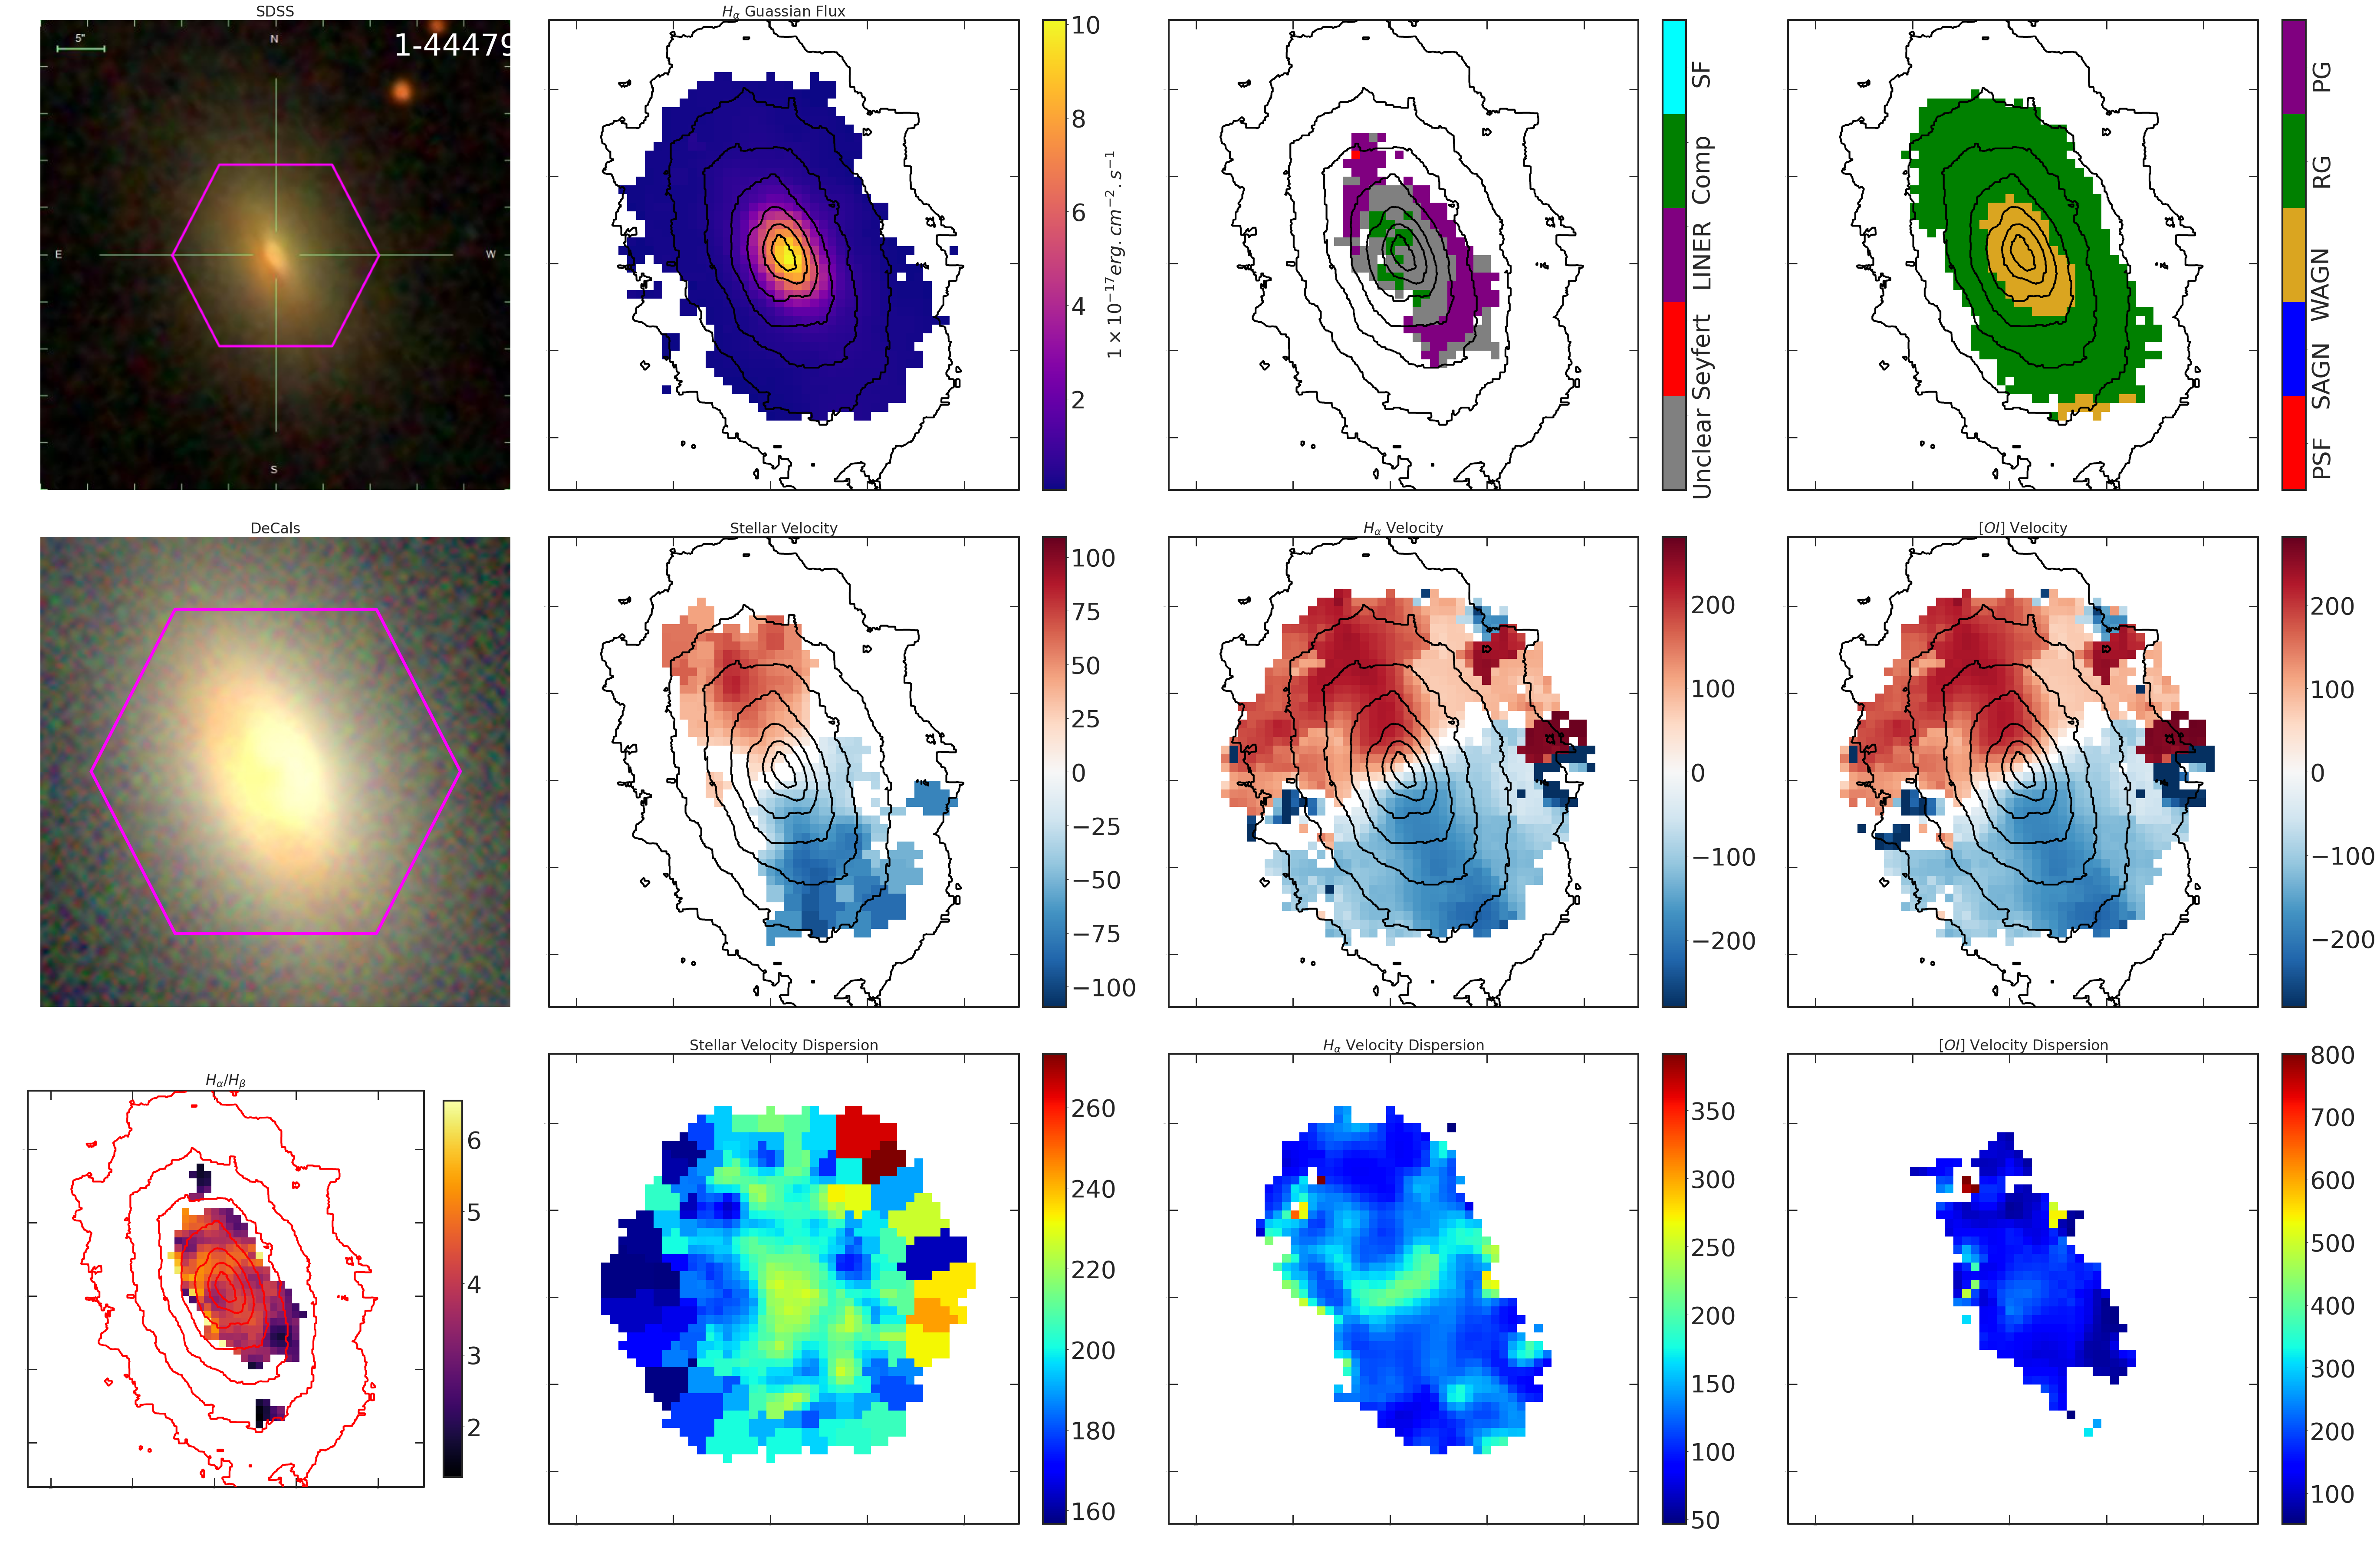

In [25]:
for mangaid in df['MANGAID']:
    plateifu = df[df['MANGAID']==mangaid]['PLATEIFU'].values[0]
    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid = maps.mangaid

    gs = gridspec.GridSpec(ncols=4, nrows=3, width_ratios = [0.8,1,1,1], wspace=0.0001,hspace=0.1)
    fig = plt.figure(figsize = (70,45))

    # Set the size of image cutout
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    ax = fig.add_subplot(gs[0,0], projection = optical.wcs)
    ax.imshow(optical.data, extent = [-1,1,-1,1])
    ax.set_title('SDSS')
    ax.annotate(f'{mangaid}', (0.5,0.85), color = 'White', fontsize = 50)
    ax.axis('Off')

    # Crop Image to match IFU size

    optical.get_new_cutout(size,size,size/512)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    scale_s = optical.wcs.to_header()['PC2_2']*3600
    size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

    # Decals
    img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

    ax1 = fig.add_subplot(gs[1,0], projection = img.wcs)
    ax1.grid(False)
    ax1.imshow(img.image)
    optical.overlay_hexagon(ax1, linewidth = 5)
    ax1.set_title('DeCals')
    ax1.axis('Off')
    ax1.grid(False)

    # H alpha

    ax = fig.add_subplot(gs[0,1], projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_ha_6564

    ax.grid(False)
    cbr = mapplot.plot(dapmap=np.log10(ha),return_cbrange=True)

    img = ax.imshow((goodspax(ha,SNR = 3)),cmap='plasma')
    ax.grid(False)
    ax.set_autoscale_on(False)
    ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
              linewidths = 3)
    ax.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)

    ax.set_title(r'$H_{\alpha}$ Guassian Flux')
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax, shrink=1, anchor = (-0.1,0.5))
    cb.set_label(r'$1\times10^{-17}erg.cm^{-2}.s^{-1}$', labelpad = 5, fontsize = 30)
    cb.ax.tick_params(labelsize=40)

    # BPT
    ax4 = fig.add_subplot(gs[0,2],projection=maps.wcs,slices=('x','y',0))
    m, f ,a = maps.get_bpt(show_plot=False)

    SF   = m['sf']['global'].astype('float64')*5
    COMP = m['comp']['global'].astype('float64')*4
    LIN  = m['liner']['global'].astype('float64')*3
    SEY  = m['seyfert']['global'].astype('float64')*2
    AMB  = m['ambiguous']['global'].astype('float64')*1

    bpt = SF + COMP + LIN + SEY + AMB

    cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])

    bpt[bpt==0]=np.nan
    img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)
    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('BPT')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img, ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.set_ticks([1.3, 2.3, 3.3, 4.2, 5])
    cb.set_ticklabels(['Unclear','Seyfert','LINER','Comp', 'SF'], rotation = 90,fontsize = 30)
    cb.ax.tick_params(labelsize=40)

    # WHAN

    ax4 = fig.add_subplot(gs[0,3],projection=maps.wcs,slices=('x','y',0))
    # WHAN Map

    # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
    nii=maps.emli40ne_gflux_nii_6585
    ha =maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf  = (logniiha < -0.4)  & (ewha.value > 3)
    sagn = (logniiha > -0.4)  & (ewha.value > 6)
    wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
    rg   = ewha.value < 3
    pg   = (ewha.value < 0.5) & (ewnii.value < 0.5)

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=3)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=3)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=3)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = np.nan


    # WHAN IFU
    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
    nocov = ewha.pixmask.get_mask('NOCOV',dtype=bool)
    mask = np.where(nocov==True,np.nan,1)
    img = ax4.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('WHAN')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'], rotation = 90, fontsize=40)
    cb.ax.tick_params(labelsize=40)


    # Stellar Velocity
    stvel = maps.stellar_vel

    ax4 = fig.add_subplot(gs[1,1],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    data = goodspax(stvel,3)
    max = np.abs(data)
    max = np.nanmedian(max)*2
    min = -max
    img = ax4.imshow(data ,cmap='RdBu_r', vmin=min,vmax=max)
    ax4.grid(False)
    ax4.set_autoscale_on(False)

    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
                colors='black',levels=levels,zorder=11,
                linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title('Stellar Velocity')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

     # H alpha Velocity
    havel = maps['emline_gvel_ha_6564']

    ax4 = fig.add_subplot(gs[1,2],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    data = goodspax(havel,3)
    max = np.abs(data)
    max = np.nanmedian(max)*2
    min = -max
    img = ax4.imshow(data ,cmap='RdBu_r', vmin=min,vmax=max)
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
                colors='black',levels=levels,zorder=11,
                linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$H_{\alpha}$ Velocity')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

    # [OI] velocity

    ovel = maps['emline_gvel_oi_5007']

    ax4 = fig.add_subplot(gs[1,3],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    data = goodspax(ovel,3)
    max = np.abs(data)
    max = np.nanmedian(max)*2
    min = -max
    img = ax4.imshow(data ,cmap='RdBu_r', vmin=min,vmax=max)
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
                colors='black',levels=levels,zorder=11,
                linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$[OI]$ Velocity')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

    """
    # OI/ha
    oi = maps.emline_gflux_oi_5007

    oi_ha = oi/ha
    ax4 = fig.add_subplot(gs[2,0],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(oi_ha,3) ,cmap='inferno')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
                colors='red',levels=levels,zorder=11,
                linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$[OI]/H_{\alpha}$')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=0.8, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)
    """
     # ha/hb

    hb = maps.emline_gflux_hb_4862
    ha_hb = ha/hb
    ax4 = fig.add_subplot(gs[2,0],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(ha_hb,3) ,cmap='inferno')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
                colors='red',levels=levels,zorder=11,
                linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$H_{\alpha}/H_{\beta}$')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=0.8, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)
    # Stellar Dispersion

    vel_sigma = maps.stellar_sigma

    ax4 = fig.add_subplot(gs[2,1],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(vel_sigma,3) ,cmap='jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
    #            colors='black',levels=levels,zorder=11,
     #           linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'Stellar Velocity Dispersion')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

    # Ha Velcoity Dispersion

    ha_sigma = maps.emline_gsigma_ha_6564

    ax4 = fig.add_subplot(gs[2,2],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(ha_sigma,3) ,cmap='jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
   #             colors='black',levels=levels,zorder=11,
   #             linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$H_{\alpha}$ Velocity Dispersion')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

     # Ha Velcoity Dispersion

    oi_sigma = maps.emline_gsigma_oi_5007

    ax4 = fig.add_subplot(gs[2,3],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(oi_sigma,3) ,cmap='jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
     #           colors='black',levels=levels,zorder=11,
      #          linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$[OI]$ Velocity Dispersion')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)
    #fig.savefig(f'Dusty/{mangaid}_{plateifu}.png',bbox_inches='tight');
    print(mangaid)
    break

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
  x = np.log10(ha_hb.value.ravel())

[WARNING]: invalid value encountered in log10 (RuntimeWarning)
  x = np.log10(ha_hb.value.ravel())



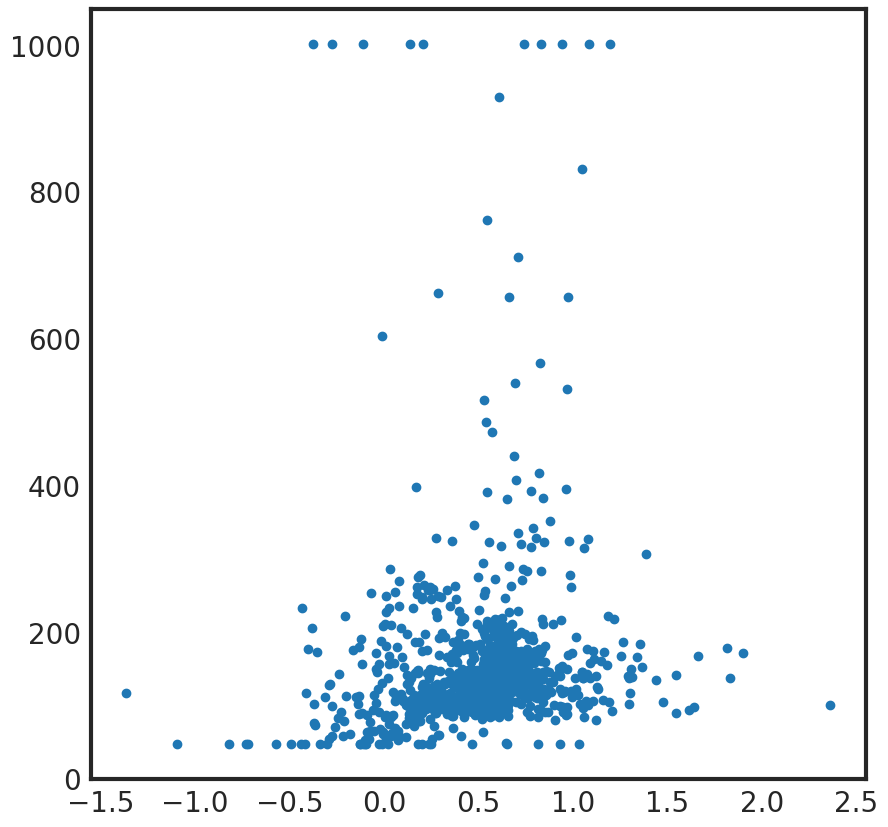

In [28]:
x = np.log10(ha_hb.value.ravel())
y = ha_sigma.value.ravel()
plt.scatter(x,y)

In [ ]:
!zip m Dusty/*

## **sSFR**

In [ ]:
fig = plt.figure(figsize = (30,150))
gs = gridspec.GridSpec(ncols=1, nrows=15)
ax_l = []
SFR_s = []
M_s   = []
sSFR_s = []
x_s = []
y_s = []

for i, plateifu in enumerate(df_SF.plateifu):

    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid = maps.mangaid


    # Set the size of image cutout
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    #optical=maps.getImage()

    # Crop Image to match IFU size

   # optical.get_new_cutout(size,size,size/512)
   # filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    #levels=[60.,  90., 120., 150., 180., 210., 240.]

    ha = maps.emline_gflux_ha_6564
    hb = maps.emline_gflux_hb_4862
    ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

    m, f ,a = maps.get_bpt(show_plot=False)
    sf = m['sf']['global'].astype('float64')

    segm      = detect_sources(sf, 0, npixels = 5)
    flag = 0
    if not isinstance(segm,type(None)):
        cat = SourceCatalog(sf, segm).to_table()
        if cat['area'].value.max()<=10:
            flag = 1
    else:
        flag = 1

    if flag:
        value = get_whan(maps);
        sf = np.where(value ==1, 1, np.nan)
        segm      = detect_sources(sf, 0, npixels = 5)
        if not isinstance(segm,type(None)):
            cat = SourceCatalog(sf, segm).to_table()
            area = cat['area'].value.max()
        else:
            area = 0
    else:
        sf = np.where(sf ==1, 1, np.nan)
        area  = cat['area'].value.max()

    ha_sf    = goodspax(ha,3)*sf
    hb_sf    = goodspax(hb,3)*sf
    ha_hb_sf = goodspax(ha_hb,3)*sf

    z = maps.dapall['z']

    fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log(ha_hb_sf/2.86))
    D_L = cosmo.luminosity_distance(z).to(u.cm)
    Lha =  (fa*4*np.pi*D_L*D_L)*(u.erg/u.second)
    SFR = pow(10,-41.1)*Lha
    SFR = SFR*(u.solMass/u.year)

    cube = maps.getCube()

    M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
    M = 10**np.where(M>-10,M,0)

    M_s.append(M.sum())

    M = M*u.solMass

    sSFR = SFR/M

    data = SFR.value
    ind = np.where(np.isnan(data),False,True)

    SFR_s.append(np.median(data[ind]))

    data = sSFR.value
    ind = np.where(np.isnan(data),False,True)
    sSFR_s.append(np.median(data[ind]))

    ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)

    img = ax4.imshow(np.log10(sSFR.value), cmap = 'jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    #.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
    ax4.coords[0].set_ticks([]*u.degree)
    ax4.coords[1].set_ticks([]*u.degree)
    ax_l.append(ax4)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.328, anchor = (0.5,1.09))
cb.set_label('Log (sSFR)' + r' $[yr^{-1}]$', labelpad = 15)
plt.subplots_adjust(hspace = 0.01)

In [ ]:
sSFR_s = np.log10(np.array(sSFR_s))

In [ ]:
M_s = np.log10(np.array(M_s))

In [ ]:
M_s

## **SFRD**

In [ ]:
fig = plt.figure(figsize = (30,120))
gs  = gridspec.GridSpec(ncols=1, nrows=12)
ax_l =[]
SFR_s = []
x_s = []
y_s = []
for i, plateifu in enumerate(df_SF[:5].plateifu):

    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid = maps.mangaid


    # Set the size of image cutout
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    # Crop Image to match IFU size

    optical.get_new_cutout(size,size,size/512)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]

    ha = maps.emline_gflux_ha_6564
    hb = maps.emline_gflux_hb_4862
    ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

    m, f ,a  = maps.get_bpt(show_plot=False)
    sf       = m['sf']['global'].astype('float64')

    if sf.max()==0.0:
        value = get_whan(maps);
        sf = np.where(value ==1, 1, 0)

    ha_sf    = ha*sf
    hb_sf    = hb*sf
    ha_hb_sf = ha_hb*sf

    z = maps.dapall['z']

    fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log(ha_hb_sf.value/2.86))
    D_L = cosmo.luminosity_distance(z).to(u.cm)
    Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
    SFR = 5.5e-42*Lha
    SFR = SFR.value*(u.solMass/u.year)
    SFR_s.append(SFR)

    ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
    area = (ang_dist.value**2*maps.bin_area.value)
    area = area*(u.kpc**2)
    SFRD = SFR/area


    ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)

    img = ax4.imshow(np.log10(SFRD.value), cmap = 'hsv')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
    ax4.coords[0].set_ticks([]*u.degree)
    ax4.coords[1].set_ticks([]*u.degree)
    ax_l.append(ax4)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.328, anchor = (0.5,1.09))
cb.set_label('Log (SFRD)' + r' $[M_{\odot}kpc^{-2}yr^{-1}]$')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
t = SFR_s

SFRS = []
for i in t:
  m = (i.value[(np.isnan(i.value)==False) & (np.isinf(i.value)==False) &(i.value>0)])
  print(np.median(m))
  SFRS.append(np.median(m))

In [ ]:
df_noSF['SFR_m'] = SFRS

In [ ]:
for x,y in zip(x_s,SFR_s):
  plt.scatter(x,y)
  plt.yscale('log')
  plt.ylim(1e-8,1e1)
  plt.show()

In [ ]:
S = []
for i in SFR_s:
  S.append(np.where(np.isnan(i),0,i).mean().value)

In [ ]:
t = df_SF['lgMHI'] - np.log10(S)

In [ ]:

  ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
  area = (ang_dist.value**2*maps.bin_area.value)
  area = area*(u.kpc**2)
  SFRD = SFR/area

  R   = maps.spx_ellcoo_elliptical_radius.value
  R_e = float(maps.header['reff'])

  x = (R/R_e)
  y = SFRD

  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot()
  ax.scatter(x,y)
  ax.set_xlabel(r'$R/R_e$')
  ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')

  ax.xaxis.set_minor_locator(AutoMinorLocator())
  ax.yaxis.set_minor_locator(AutoMinorLocator())

  ax.tick_params(which='both', width=2,direction="in")
  ax.tick_params(which='major', length=7,direction="in")
  ax.tick_params(which='minor', length=4, color='black',direction="in")

#### **H-alpha Velocity**

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l = []
for i,mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  havel = maps['emline_gvel_ha_6564']
  data = havel

  ax = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  img = ax.imshow(goodspax(data,type = 'vel', SNR = 0),
                  cmap = 'RdBu',
                  vmin = -150,vmax = 150)


  ax.grid(False)
  ax.set_autoscale_on(False)
  ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax.axis('off')
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
havel.plot()

### **Stellar velocity**

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l = []
for i,mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  stvel= maps['stellar_vel']
  data = stvel

  ax = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  img = ax.imshow(goodspax(data,type = 'vel', SNR = 0), cmap = 'RdBu',
                  vmin = -100,vmax = 100)


  ax.grid(False)
  ax.set_autoscale_on(False)
  ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax.axis('off')
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
stvel.plot()

In [ ]:
# SDSS
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)
apertures = aperture_gen(mods[:-1],0.5*dist_scale,r,
                         origin = 'center', a_offset = 20)
for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

In [ ]:
sb.color_palette()

# **Position Angle**

#### **H-alpha Velocity**

In [ ]:
fig = plt.figure(figsize = (30,220))
gs  = gridspec.GridSpec(ncols=1, nrows=22)
ax_l = []
flag_Re  = [0,0,0,0,0,0,0,1,0,1,0,0,         1,0,1,1,0,0,0,0,1,1]
flag_SNR = [1,1,1,1,1,1,1,1,1,1,1,1,         1,1,1,1,1,1,1,1,1,1]
offset   = [180,0,0,0,0,180,0,180,180,0,180,0, 0,180,0,180,0,180,0,0,180,0]
for i, plateifu in enumerate(df_SF.plateifu[:1]):

    maps = Maps(plateifu = plateifu ,mode='remote')
    mangaid = maps.mangaid

    # Set the size of image cutout
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    # Crop Image to match IFU size

    optical.get_new_cutout(size,size,size/512)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]

    havel = maps['emline_gvel_ha_6564']
    data = havel

    ax = fig.add_subplot(gs[i])

    R   = maps.spx_ellcoo_elliptical_radius.value/float(maps.header['reff'])

    if flag_Re[i]:
        mask = R > 1
    else:
        mask = R > 3

    if flag_SNR[i]:
        SNR = 3
    else:
        SNR = 0
    mask  = np.where(mask==True,1e-32,1)

    img = ax.imshow(goodspax(data,type = 'vel', SNR = SNR)*mask, extent = [-1,1,-1,1],
                  cmap = 'RdBu_r', origin = 'lower',vmin = -100,vmax = 100)


    size = data.value.shape[0]//2
    x,y  = np.mgrid[-size:size, -size:size]//2


    out1  = paf.fit_kinematic_pa(x,y,goodspax(data*mask,type = 'vel', SNR = SNR).T, plot = False)
    out1 = (out1[0] + offset[i], out1[1], out1[2])
    ax.set_title(r'$H_{\alpha}$ Velocity | ' + f'Position Angle {out1[0]}')

    ax.set_ylim(-1,1)

    x    = np.linspace(-0.7,0.7,10)
    y    = np.tan(np.pi/180*out1[0])*x
    ax.plot(x,y, '--',color = 'black', linewidth =2)

    x   = np.linspace(-1,1,10)
    y    = 0.*x + 0
    ax.plot(x,y, '-',color = 'black', linewidth = 2)

    angles = np.linspace(0,out1[0]*np.pi/180,20)
    x_arc  = 0.3*np.cos(angles)
    y_arc  = 0.3*np.sin(angles)
    ax.annotate(r'$0^{\circ}$',(1,-0.03))
    ax.plot(x_arc, y_arc, color = 'black')
    ax.axis('off')
    ax_l.append(ax)
cb=plt.colorbar(img,ax=ax_l,location = 'bottom', shrink=0.321, anchor = (0.5,0))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.05)

In [ ]:
344 -1

In [ ]:
data = fits.open('kinImage.fits')[1].data

In [ ]:
data = data[100:200,100:200]

In [ ]:
stvel = np.where(np.isnan(data), 1e-32, data)

In [ ]:
size_x = stvel.shape[0]//2
size_y = stvel.shape[1]//2

y,x = np.mgrid[-size_x:size_x, -size_y:size_y]

In [ ]:
x.shape, y.shape, stvel.shape

In [ ]:
plt.imshow(data, cmap = 'jet')

In [ ]:
out1  = paf.fit_kinematic_pa(x,y, stvel.T, plot = True)

### **Stellar velocity**

In [ ]:
fig = plt.figure(figsize = (30,220))
gs  = gridspec.GridSpec(ncols=1, nrows=22,)
ax_l = []
flag_Re  = [0,0,0,0,0,0,0,0,0,0,0,0,         0,0,0,0,0,0,0,0,0,0]
flag_SNR = [1,1,1,1,1,1,1,1,1,1,1,1,         1,1,1,1,1,1,1,1,1,1]
offset   = [0,0,180,0,0,180,180,180,180,0,180,0, 0,180,0,180,0,180,0,0,180,0]
for i,mangaid in enumerate(ids_):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  stvel = maps['stellar_vel']
  data = stvel

  ax = fig.add_subplot(gs[i])

  R   = maps.spx_ellcoo_elliptical_radius.value/float(maps.header['reff'])

  if flag_Re[i]:
    mask = R > 1
  else:
    mask = R > 3

  if flag_SNR[i]:
    SNR = 3
  else:
    SNR = 0

  mask  = np.where(mask==True,1e-32,1)
  data= data*mask

  img = ax.imshow(goodspax(data,type = 'vel',SNR = SNR), cmap = 'RdBu_r',
                  extent =[-1,1,-1,1], origin = 'lower', vmin =-100, vmax = 100)
  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out2  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel', SNR = SNR).T, plot = False)
  out2 = (out2[0]+offset[i], out2[1], out2[2])
  ax.set_title(f'Stellar Velocity | Position Angle {out2[0]}')
  x    = np.linspace(-1,1,10)
  y    = np.tan(np.pi/180*out2[0])*x
  ax.plot(x,y, '--',color = 'black', linewidth = 2)
  x    = np.linspace(-1,1,10)
  y    = 0.*x + 0
  ax.plot(x,y, '-',color = 'black', linewidth = 2)

  angles = np.linspace(0,out2[0]*np.pi/180,20)
  x_arc  = 0.3*np.cos(angles)
  y_arc  = 0.3*np.sin(angles)
  ax.plot(x_arc, y_arc, color = 'black')

  ax.annotate(r'$0^{\circ}$',(1,-0.03))
  ax.set_ylim(-1,1)
  ax.axis('off')
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'bottom', shrink=0.321, anchor = (0.5,0))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
289  - 302.5

In [ ]:
239.0 -180

In [ ]:
stvel.plot()

In [ ]:
mangaid

In [ ]:
# SDSS
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)
apertures = aperture_gen(mods[:-1],0.5*dist_scale,r,
                         origin = 'center', a_offset = 20)
for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

# **MaNGA Cube animation**

In [ ]:
maps = Maps(plateifu ='7977-3701',mode='remote')

In [ ]:
ha = maps.emline_gflux_ha

In [ ]:
cube = maps.getCube()

In [ ]:
flux = cube.flux
y    = flux.value
x    = flux.wavelength.value

In [ ]:
!mkdir images

In [ ]:
for i in range(220):
  fig = plt.figure(figsize = (25,8))
  gs = gridspec.GridSpec(1,2,width_ratios=[1,2])
  ax1 = fig.add_subplot(gs[0],projection = cube.wcs, slices = ('x','y',0))
  ax2 = fig.add_subplot(gs[1])
  im = ax1.imshow(y[i*20], cmap= 'jet')
  pl = ax2.plot(x,y.sum(axis=(1,2)), color ='purple')
  ax2.set_ylim(0,500)
  y_l = np.linspace(0,500,10)
  x_l = y_l*0 + x[i*20]
  ax2.plot(x_l,y_l, color ='black')
  ax2.set_ylabel(r'Flux [1x$10^{-17}]$ $ergs/s/cm^2$')
  ax2.set_xlabel('Wavelength [Å]')
  fig.savefig(f'images/img{i}.png')
  plt.close()

In [ ]:
!mkdir images

In [ ]:
writer = anim.FFMpegWriter(
    fps=1, metadata=dict(artist='Me'), bitrate=1800)
ani.save("movie.mp4", writer=writer)